# 📦 FastMRI Mask Bundle – Full Rebuild & Validation
**train / val / leaderboard × brain / knee × acc4 / acc8** 의 모든 k‑space 마스크를
하나의 번들(`precomputed_masks.npz`)로 재구성하고, 누락 항목을 자동 생성합니다.

실행 완료 시
1. `metaData/precomputed_masks.npz`, `mask_bundle_index.json` 저장
2. acc4↔8 양방향 커버리지 **✅** 확인
3. 모든 마스크 시각화

— 경로(`DATA_DIR`)만 수정 후 **런올(▶)** 하면 됩니다 —

In [15]:
import os, re, glob, h5py, numpy as np, json, warnings, matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
warnings.filterwarnings("ignore")

# === 수정 ===
DATA_DIR = "/home/swpants05/Desktop/2025_FastMri/Data"
SAVE_DIR = "/home/swpants05/Desktop/2025_FastMri/Data/2025GeekSeek/metaData"
os.makedirs(SAVE_DIR, exist_ok=True)
BUNDLE_P = os.path.join(SAVE_DIR, "precomputed_masks.npz")
META_P   = os.path.join(SAVE_DIR, "mask_bundle_index.json")

REG   = re.compile(r"(brain|knee)_acc([48])_(\d+)\.h5")
LBREG = re.compile(r"(brain|knee)_test(\d+)\.h5")


In [16]:
def list_files(split:str):
    if split in ("train","val"):
        return sorted(glob.glob(os.path.join(DATA_DIR, split, "kspace", "*.h5")))
    return sorted(glob.glob(os.path.join(DATA_DIR, split, "acc*", "kspace", "*.h5")))

def load_mask(p):
    with h5py.File(p,'r') as f: return f['mask'][()].astype(bool)

mask_dict = {}
origin    = {}   # key -> example filepath

for split in ("train","val","leaderboard"):
    for p in tqdm(list_files(split), desc=split):
        fname = os.path.basename(p)
        m = load_mask(p)
        mm = REG.search(fname)
        if mm:
            body, acc, _ = mm.groups()
        else:
            mm = LBREG.search(fname)
            if not mm: continue
            body, _ = mm.groups()
            acc = "4" if "/acc4/" in p else "8"
        key = f"{body}_x{acc}_{m.shape[0]}"
        if key not in mask_dict:
            mask_dict[key] = m
            origin[key]    = p
print("Unique masks collected:", len(mask_dict))


train:   0%|          | 0/340 [00:00<?, ?it/s]

val:   0%|          | 0/60 [00:00<?, ?it/s]

leaderboard:   0%|          | 0/116 [00:00<?, ?it/s]

Unique masks collected: 19


In [17]:
# -------- coverage check & missing list --------
def bundle_set(d):
    return {(k.split('_')[0], int(k.split('_x')[1].split('_')[0]), int(k.split('_')[-1])) 
            for k in d}

bundle_s = bundle_set(mask_dict)

def list_k(acc):
    return (glob.glob(os.path.join(DATA_DIR,"train","kspace",f"*acc{acc}_*.h5")) +
            glob.glob(os.path.join(DATA_DIR,"val","kspace",f"*acc{acc}_*.h5")))

missing = []
for src,tgt in [(4,8),(8,4)]:
    for p in list_k(src):
        m = REG.search(os.path.basename(p))
        if not m: continue
        body,_acc,_ = m.groups()
        with h5py.File(p) as f:
            N = f['mask'].shape[0]
        if (body, tgt, N) not in bundle_s:
            missing.append((body, tgt, N))
missing = sorted(set(missing))
print("Missing combos:", missing)


Missing combos: [('knee', 4, 338), ('knee', 4, 386), ('knee', 8, 356), ('knee', 8, 480)]


In [18]:
# -------- generation rules --------
CENTER_W_BRAIN = 33
CENTER_MAP_KNEE = {320:26, 322:26, 338:27, 356:28, 368:29,
                   370:31, 372:33, 386:33, 388:33, 480:39}

def make_mask(N, accel, centerW):
    m = np.zeros(N, bool)
    mid = N//2
    left = mid - centerW//2
    m[left:left+centerW] = True
    m[0::accel] = True
    return m

added=[]
for body, acc, N in missing:
    # try to inherit centerW from same N other acc
    candidates=[mask_dict[k] for k in mask_dict
                if k.startswith(body) and k.endswith(f"_{N}")]
    if candidates:
        centerW = candidates[0].sum()//1   # contiguous block width, safe
        centerW = int(centerW)             # bool sum == centerW + sampled lines; crude
        # refine: contiguous range
        nz = np.where(candidates[0])[0]
        run = 1
        start = nz[0]
        for i in nz[1:]:
            if i==run+start:
                run+=1
            else:
                break
        centerW = run
    else:
        if body=="brain":
            centerW=CENTER_W_BRAIN
        else:
            centerW=CENTER_MAP_KNEE.get(N, 29)
    new_m = make_mask(N, acc, centerW)
    key = f"{body}_x{acc}_{N}"
    mask_dict[key]=new_m
    origin[key]="generated"
    added.append(key)
print("Generated:", added if added else "none")


Generated: ['knee_x4_338', 'knee_x4_386', 'knee_x8_356', 'knee_x8_480']


In [19]:
np.savez_compressed(BUNDLE_P, **mask_dict)
meta=[dict(key=k, body=k.split('_')[0],
           acc=int(k.split('_x')[1].split('_')[0]),
           N=int(k.split('_')[-1]),
           origin=origin[k]) for k in mask_dict]
with open(META_P,"w") as f: json.dump(meta,f,indent=2)
print("Bundle saved →", BUNDLE_P)


Bundle saved → /home/swpants05/Desktop/2025_FastMri/Data/2025GeekSeek/metaData/precomputed_masks.npz


## All masks visual

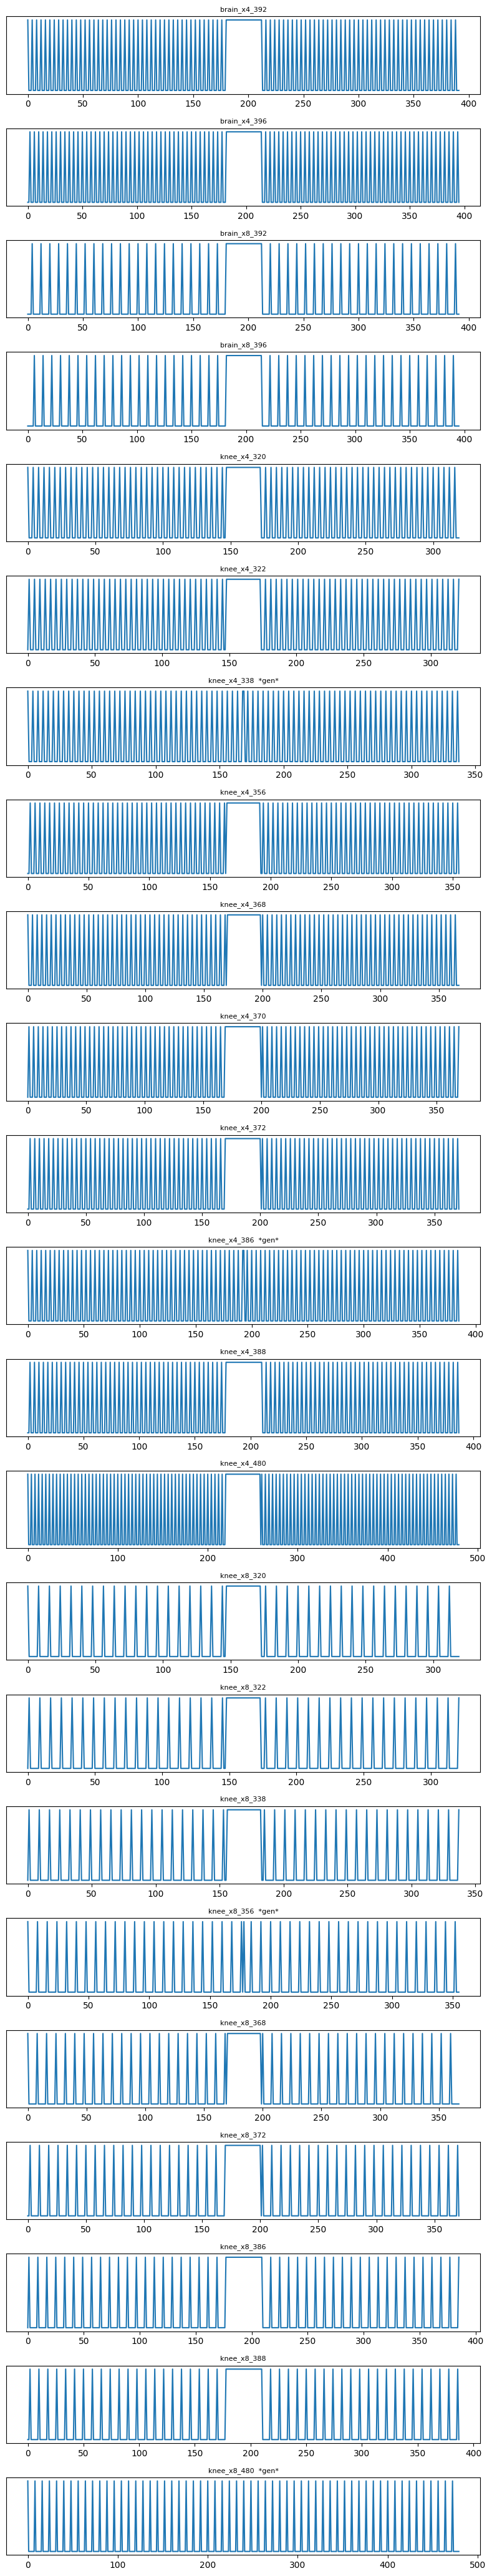

In [20]:
import math
keys_sorted=sorted(mask_dict, key=lambda x:(x.split('_')[0], int(x.split('_x')[1].split('_')[0]), int(x.split('_')[-1])))
rows=len(keys_sorted)
plt.figure(figsize=(8, 1.8*rows))
for i,k in enumerate(keys_sorted):
    plt.subplot(rows,1,i+1)
    plt.plot(mask_dict[k].astype(int))
    plt.yticks([])
    plt.title(k + ("  *gen*" if origin[k]=="generated" else ""), fontsize=8)
plt.tight_layout(); plt.show()


## Final coverage verification

In [21]:
def missing_dir(src_acc, tgt_acc):
    miss=[]
    for p in list_k(src_acc):
        m=REG.search(os.path.basename(p)); 
        if not m: continue
        body,_a,_=m.groups()
        with h5py.File(p) as f: N=f['mask'].shape[0]
        if (body, tgt_acc, N) not in bundle_set(mask_dict):
            miss.append((body,N))
    return sorted(set(miss))

for src,tgt in [(4,8),(8,4)]:
    miss=missing_dir(src,tgt)
    print(f"acc{src}→acc{tgt} :", '✅ ok' if not miss else f'❌ {miss}')


acc4→acc8 : ✅ ok
acc8→acc4 : ✅ ok
